<a href="https://colab.research.google.com/github/jedcheng/micromagnetic_std_problem4/blob/main/std_problem4_torch_3D_Solver_Double_Thickness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
try:
    import google.colab
except ImportError:
    pass
else:
    !wget https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
    !tar -xvf mumax3.10_linux_cuda10.1.tar.gz
    !rm mumax3.10_linux_cuda10.1.tar.gz
    !rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10
    import os
    os.environ['PATH'] += ":/content/mumax3.10"

!cp mumax3.10/mumax3 mumax3
!pip install -q multiprocess

--2023-06-19 01:46:55--  https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
Resolving mumax.ugent.be (mumax.ugent.be)... 157.193.40.77
Connecting to mumax.ugent.be (mumax.ugent.be)|157.193.40.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150707207 (144M) [application/x-gzip]
Saving to: ‘mumax3.10_linux_cuda10.1.tar.gz’

mumax3.10_linux_cud 100%[===================>] 143.73M  13.2MB/s    in 13s     

2023-06-19 01:47:09 (11.3 MB/s) - ‘mumax3.10_linux_cuda10.1.tar.gz’ saved [150707207/150707207]

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


In [29]:
mumax_script = """
SetGridsize(166, 42, 2)
SetCellsize(3e-9, 3e-9, 3e-9)

Msat  = 800e3
Aex   = 13e-12
alpha = 0.02

m = uniform(1, .1, 0)
relax()
save(m)    // relaxed state

autosave(m, 200e-12)
tableautosave(10e-12)

B_ext = vector(-24.6E-3, 4.3E-3, 0)
run(1e-9)
"""

with open("test.mx3", "w") as f:
  f.write(mumax_script)

In [30]:
!./mumax3 test.mx3

//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: Tesla T4(15101MB), CUDA Driver 12.0, cc=7.5, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: test.out/
//starting GUI at http://127.0.0.1:35367
SetGridsize(166, 42, 2)
SetCellsize(3e-9, 3e-9, 3e-9)
Msat = 800e3
Aex = 13e-12
alpha = 0.02
m = uniform(1, .1, 0)
relax()
//Using cached kernel: /tmp/mumax3kernel_[166 42 2]_[0 0 0]_[3e-09 3e-09 3e-09]_6_
save(m)
autosave(m, 200e-12)
tableautosave(10e-12)
B_ext = vector(-24.6E-3, 4.3E-3, 0)
run(1e-9)
//********************************************************************//
//Please cite

In [31]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [32]:
df = pd.read_csv("/content/test.out/table.txt", sep="\t")
t = df["# t (s)"].to_numpy()
mx = df["mx ()"].to_numpy()
my = df["my ()"].to_numpy()
mz = df["mz ()"].to_numpy()

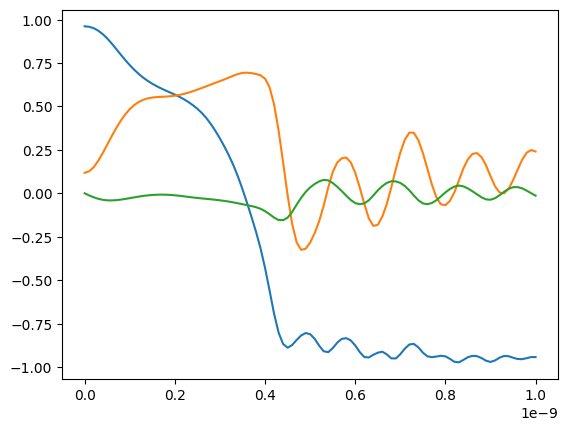

In [33]:
plt.plot(t, mx)
plt.plot(t, my)
plt.plot(t, mz)



In [34]:
import numpy as np
from numba import jit, njit, prange
from torch.fft import fftn, ifftn
import time
import torch
import math






@jit(nopython=True, parallel=True)
def calcDemagTensor(nx, ny, nz, dd, Kxx, Kxy, Kxz, Kyy, Kyz, Kzz, prefactor):
    for K in prange(-nz, nz):
        for J in prange(-ny, ny):
            for I in prange(-nx, nx):
                if I == 0 and J == 0 and K == 0:
                    continue
                L = I + nx
                M = J + ny
                N = K + nz
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            r = math.sqrt((I + i - 0.5) * (I + i - 0.5) * dd * dd + (J + j - 0.5) * (J + j - 0.5) * dd * dd + (K + k - 0.5) * (K + k - 0.5) * dd * dd)
                            Kxx[L, M, N] += (-1) ** (i + j + k) * math.atan((K + k - 0.5) * (J + j - 0.5) * dd / r / (I + i - 0.5))
                            Kxy[L, M, N] += (-1) ** (i + j + k) * math.log((K + k - 0.5) * dd + r)
                            Kxz[L, M, N] += (-1) ** (i + j + k) * math.log((J + j - 0.5) * dd + r)
                            Kyy[L, M, N] += (-1) ** (i + j + k) * math.atan((I + i - 0.5) * (K + k - 0.5) * dd / r / (J + j - 0.5))
                            Kyz[L, M, N] += (-1) ** (i + j + k) * math.log((I + i - 0.5) * dd + r)
                            Kzz[L, M, N] += (-1) ** (i + j + k) * math.atan((J + j - 0.5) * (I + i - 0.5) * dd / r / (K + k - 0.5))
                Kxx[L, M, N] *= prefactor
                Kxy[L, M, N] *= -prefactor
                Kxz[L, M, N] *= -prefactor
                Kyy[L, M, N] *= prefactor
                Kyz[L, M, N] *= -prefactor
                Kzz[L, M, N] *= prefactor

    return Kxx, Kxy, Kxz, Kyy, Kyz, Kzz



In [35]:
data_type = torch.float32
saving_step = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
def time_function(t, dt, Hx, Hy, Hz, alpha, prefactor1, prefactor2):
    # time function
    # apply this to get into the s-state
    if t < 4000:
        Hx += 100
        Hy += 100
        Hz += 100

    # reduced the field to 0
    elif t < 6000:
        Hx += (6000 - t)/20
        Hy += (6000 - t)/20
        Hz += (6000 - t)/20



    # start applying the field for the standard problem 4a
    elif t > 50000:
        Hx -= 19.576
        Hy += 3.422
        alpha = 0.02
        prefactor1 = (-0.221) * dt / (1 + alpha**2)
        prefactor2 = prefactor1 * alpha /Ms


    return Hx, Hy, Hz, alpha, prefactor1, prefactor2

In [37]:


nx = 166  # number of cells on x direction
ny = 42
nz = 2
dd = 3  # cell volume = dd x dd x dd
dt = 5E-6  # timestep in nanoseconds

timesteps = 250000
alpha = 0.5  # damping constant to relax system to S-state
exchConstant = 1.3E-11 * 1E18  # nanometer/nanosecond units

mu_0 = 1.256636  # vacuum permeability, = 4 * pi / 10
Ms = 800  # saturation magnetization
exch = 2 * exchConstant / mu_0 / Ms / Ms
prefactor1 = (-0.221) * dt / (1 + alpha * alpha)
prefactor2 = prefactor1 * alpha / Ms

Mx = torch.full((nx, ny, nz), Ms, dtype=data_type, device=device)  # magnetization on x direction
My = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnetization on y direction
Mz = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnetization on z direction

deltaMx = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on x direction
deltaMy = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on y direction
deltaMz = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # change of magnetization on z direction
mag = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # magnitude of magnetization


Kxx = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)  # Initialization of demagnetization tensor
Kxy = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kxz = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kyy = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kyz = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
Kzz = np.zeros((nx * 2, ny * 2, nz * 2), dtype=np.float32)
prefactor = 1 / (4 * torch.pi)





In [38]:
Kxx, Kxy, Kxz, Kyy, Kyz, Kzz = calcDemagTensor(nx, ny, nz, dd, Kxx, Kxy, Kxz, Kyy, Kyz, Kzz, prefactor)

Kxx = torch.from_numpy(Kxx).float().to(device)
Kxy = torch.from_numpy(Kxy).float().to(device)
Kxz = torch.from_numpy(Kxz).float().to(device)
Kyy = torch.from_numpy(Kyy).float().to(device)
Kyz = torch.from_numpy(Kyz).float().to(device)
Kzz = torch.from_numpy(Kzz).float().to(device)

In [39]:
Kxx_fft = fftn(Kxx)  # fast fourier transform of demag tensor
Kxy_fft = fftn(Kxy)
Kxz_fft = fftn(Kxz)
Kyy_fft = fftn(Kyy)
Kyz_fft = fftn(Kyz)
Kzz_fft = fftn(Kzz)

Hx_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on x direction
Hy_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on y direction
Hz_exch = torch.zeros((nx, ny, nz), dtype=data_type, device=device)  # exchange field on z direction


Hx0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx4 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hx5 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

Hy0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy4 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hy5 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

Hz0 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz1 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz2 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz3 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz4 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)
Hz5 = torch.zeros((nx, ny, nz), dtype=data_type, device=device)

t_array = torch.zeros(int(timesteps/saving_step))
Mx_mean_array = torch.zeros(int(timesteps/saving_step))
My_mean_array = torch.zeros(int(timesteps/saving_step))
Mz_mean_array = torch.zeros(int(timesteps/saving_step))
t_taken_array = torch.zeros(int(timesteps/saving_step))

In [40]:
start_time = time.time()
print_start_time = time.time()
for t in range(timesteps):

    Mx = torch.nn.functional.pad(Mx, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)
    My = torch.nn.functional.pad(My, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)
    Mz = torch.nn.functional.pad(Mz, pad=(0, nz, 0, ny, 0, nx), mode='constant', value=0)

    Mx_FFT = fftn(Mx)
    My_FFT = fftn(My)
    Mz_FFT = fftn(Mz)

    Hx = ifftn(Mx_FFT * Kxx_fft + My_FFT * Kxy_fft + Mz_FFT * Kxz_fft)  # calc demag field with fft
    Hy = ifftn(Mx_FFT * Kxy_fft + My_FFT * Kyy_fft + Mz_FFT * Kyz_fft)
    Hz = ifftn(Mx_FFT * Kxz_fft + My_FFT * Kyz_fft + Mz_FFT * Kzz_fft)

    Hx = torch.real(Hx[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])  # truncation of demag field
    Hy = torch.real(Hy[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])
    Hz = torch.real(Hz[nx:(2 * nx), ny:(2 * ny), nz:(2 * nz)])
    Mx = Mx[0:nx, 0:ny, 0:nz]  # truncation of Mx, remove zero padding
    My = My[0:nx, 0:ny, 0:nz]
    Mz = Mz[0:nx, 0:ny, 0:nz]


    # todo: get rid of this
    Hx0[1:, :, :] = Mx[:-1, :, :]  # -x
    Hx0[0, :, :] = Hx0[1, :, :]
    Hx1[:-1, :, :] = Mx[1:, :, :]  # +x
    Hx1[-1, :, :] = Hx1[-2, :, :]

    Hx2[:, 1:, :] = Mx[:, :-1, :]  # -y
    Hx2[:, 0, :] = Hx2[:, 1, :]
    Hx3[:, :-1, :] = Mx[:, 1:, :]  # +y
    Hx3[:, -1, :] = Hx3[:, -2, :]

    Hx4[:,:,1:] = Mx[:,:,:-1]
    Hx4[:,:,0] = Hx4[:,:,1]
    Hx5[:,:,:-1] = Mx[:,:,1:]
    Hx5[:,:,-1] = Hx5[:,:,-2]

    Hy0[1:, :, :] = My[:-1, :, :]
    Hy0[0, :, :] = Hy0[1, :, :]
    Hy1[:-1, :, :] = My[1:, :, :]
    Hy1[-1, :, :] = Hy1[-2, :, :]

    Hy2[:, 1:, :] = My[:, :-1, :]
    Hy2[:, 0, :] = Hy2[:, 1, :]
    Hy3[:, :-1, :] = My[:, 1:, :]
    Hy3[:, -1, :] = Hy3[:, -2, :]

    Hy4[:,:,1:] = My[:,:,:-1]
    Hy4[:,:,0] = Hy4[:,:,1]
    Hy5[:,:,:-1] = My[:,:,1:]
    Hy5[:,:,-1] = Hy5[:,:,-2]

    Hz0[1:, :, :] = Mz[:-1, :, :]
    Hz0[0, :, :] = Hz0[1, :, :]
    Hz1[:-1, :, :] = Mz[1:, :, :]
    Hz1[-1, :, :] = Hz1[-2, :, :]

    Hz2[:, 1:, :] = Mz[:, :-1, :]
    Hz2[:, 0, :] = Hz2[:, 1, :]
    Hz3[:, :-1, :] = Mz[:, 1:, :]
    Hz3[:, -1, :] = Hz3[:, -2, :]

    Hz4[:,:,1:] = Mz[:,:,:-1]
    Hz4[:,:,0] = Hz4[:,:,1]
    Hz5[:,:,:-1] = Mz[:,:,1:]
    Hz5[:,:,-1] = Hz5[:,:,-2]


    Hx += exch / dd / dd * (Hx0 + Hx1 + Hx2 + Hx3 + Hx4 + Hx5 - 6*Mx)
    Hy += exch / dd / dd * (Hy0 + Hy1 + Hy2 + Hy3 + Hy4 + Hy5 - 6*My)
    Hz += exch / dd / dd * (Hz0 + Hz1 + Hz2 + Hz3 + Hz4 + Hz5 - 6*Mz)


    Hx, Hy, Hz, alpha, prefactor1, prefactor2 = time_function(t, dt, Hx, Hy, Hz, alpha, prefactor1, prefactor2)




    MxHx = My * Hz - Mz * Hy  # calculation of M x H
    MxHy = Mz * Hx - Mx * Hz
    MxHz = Mx * Hy - My * Hx


    deltaMx = prefactor1 * MxHx + prefactor2 * (My * MxHz - Mz * MxHy)  # calculation of deltaM
    deltaMy = prefactor1 * MxHy + prefactor2 * (Mz * MxHx - Mx * MxHz)
    deltaMz = prefactor1 * MxHz + prefactor2 * (Mx * MxHy - My * MxHx)

    Mx += deltaMx  # update M
    My += deltaMy
    Mz += deltaMz

    mag = torch.sqrt(Mx ** 2 + My ** 2 + Mz ** 2)  # normalization of M
    Mx = Mx / mag * Ms
    My = My / mag * Ms
    Mz = Mz / mag * Ms



    if t % saving_step == 0:

        MxMean = torch.mean(Mx)
        MyMean = torch.mean(My)
        MzMean = torch.mean(Mz)
        time_taken = time.time() - start_time

        # todo: improve saving process
        output_index = int(t/saving_step) - 1
        t_array[output_index] = t
        Mx_mean_array[output_index] = MxMean
        My_mean_array[output_index] = MyMean
        Mz_mean_array[output_index] = MzMean
        t_taken_array[output_index] = time_taken

        if t % (10*saving_step) == 0:
            print_time = time.time() - print_start_time
            print(f"t = {t}, MxMean = {MxMean}, MyMean = {MyMean}, MzMean = {MzMean}, time taken = {print_time}s")
            print_start_time = time.time()

        start_time = time.time()


t = 0, MxMean = 800.0, MyMean = 0.10608009248971939, MzMean = -0.035361405462026596, time taken = 0.013316631317138672s
t = 10000, MxMean = 705.591796875, MyMean = 352.9359436035156, MzMean = 28.99202537536621, time taken = 33.089860916137695s
t = 20000, MxMean = 752.9119262695312, MyMean = 194.34835815429688, MzMean = 13.803966522216797, time taken = 20.593071699142456s
t = 30000, MxMean = 762.8455200195312, MyMean = 127.56549835205078, MzMean = 5.084868431091309, time taken = 20.67005944252014s
t = 40000, MxMean = 766.0570678710938, MyMean = 105.74160766601562, MzMean = 1.6402130126953125, time taken = 19.733352661132812s
t = 50000, MxMean = 767.5298461914062, MyMean = 98.78546142578125, MzMean = 0.568673849105835, time taken = 20.55166792869568s
t = 60000, MxMean = 713.3253173828125, MyMean = 222.77081298828125, MzMean = -31.556135177612305, time taken = 21.7516610622406s
t = 70000, MxMean = 593.1103515625, MyMean = 385.2035827636719, MzMean = -22.15671157836914, time taken = 19.887

In [41]:
import pandas as pd

df = pd.DataFrame({'t': t_array,
                   'Mx_mean': Mx_mean_array,
                   'My_mean': My_mean_array,
                   'Mz_mean': Mz_mean_array,
                   't_taken': t_taken_array})

df.to_csv('std_problem4.csv', index=False)

In [42]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [49]:
t_array_ns = t_array *  5e-6 / 1e9

In [50]:
df = pd.read_csv("/content/test.out/table.txt", sep="\t")
t = df["# t (s)"].to_numpy()
mx = df["mx ()"].to_numpy()
my = df["my ()"].to_numpy()
mz = df["mz ()"].to_numpy()

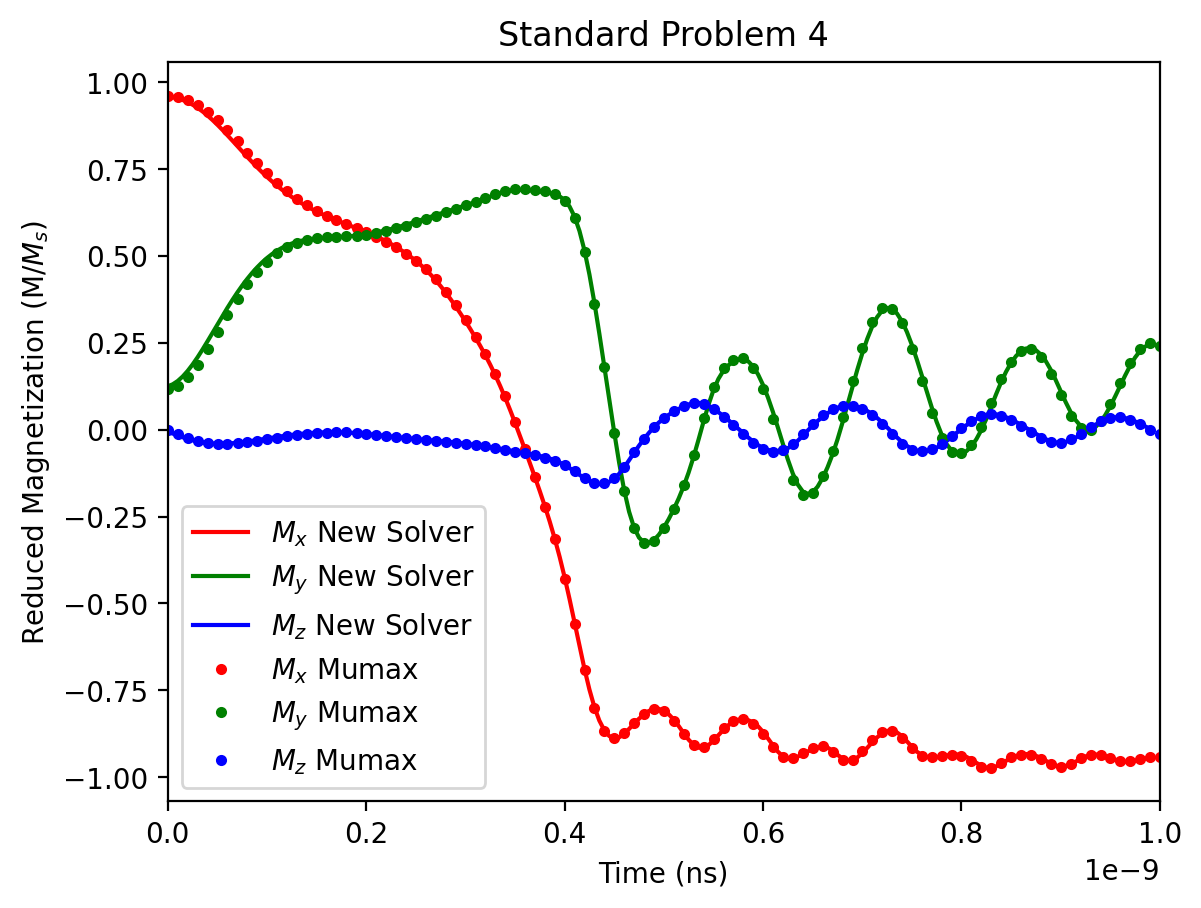

In [52]:
plt.plot(t_array_ns[50:-1] - t_array_ns[50] , Mx_mean_array[50:-1]/Ms, 'r', label='$M_x$ New Solver')
plt.plot(t_array_ns[50:-1] - t_array_ns[50], My_mean_array[50:-1]/Ms, 'g', label='$M_y$ New Solver')
plt.plot(t_array_ns[50:-1] - t_array_ns[50], Mz_mean_array[50:-1]/Ms, 'b', label='$M_z$ New Solver')
plt.plot(t, mx, "r.", label='$M_x$ Mumax')
plt.plot(t, my, "g.", label='$M_y$ Mumax')
plt.plot(t, mz, "b.", label='$M_z$ Mumax')
plt.xlim(0, 1e-9)

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Reduced Magnetization (M/$M_s$)')
plt.title('Standard Problem 4')
plt.savefig('std_prob4_mumax3_3D_double_thickness.png', dpi=300)
plt.show()